In [1]:
import os
import math

import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from VectorSpaceModel import *
from KNNClassifier import *

In [2]:
# define constants
PATH = "./20news-18828/"

In [3]:
# generate file path of training set and testing set
subdirs = os.listdir(PATH)
training_set_fns = []
test_set_fns = []
for dir_ in subdirs:
    files = os.listdir(PATH+dir_)
    splitting_pos = math.floor(len(files)*0.8)
    training_set_fns.extend(os.path.join(dir_, fn) for fn in files[:splitting_pos])
    test_set_fns.extend(os.path.join(dir_, fn) for fn in files[splitting_pos:])

In [4]:
print('The training set contains %d files' % len(training_set_fns))
print('The testing set contains %d files' % len(test_set_fns))

The training set contains 15056 files
The testing set contains 3772 files


In [5]:
# read documents of training set
training_docs = []
for fn in training_set_fns:
    with open(PATH+fn, encoding='latin1') as f:
        training_docs.append(f.read())

In [6]:
# preprocess training docs
stop_words = set(stopwords.words('english'))
def filter_stop_words(doc):
    return filter(lambda w: w not in stop_words, doc)

tokenized_docs = []
tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer("english", ignore_stopwords=True)
for doc in training_docs:
    word_tokens = tokenizer.tokenize(doc) # Tokenization
    word_stems = [stemmer.stem(w.lower()) for w in word_tokens] # Stemming/normalization
    word_without_stopwords = filter_stop_words(word_stems) # Stopword/controlled vocabulary filtering
    tokenized_docs.append(word_without_stopwords)

In [7]:
# get the VSM representation of each training document
vsms = []
for doc in tokenized_docs:
    vsm = VectorSpaceModel(doc)
    VectorSpaceModel.accumulateDocumentFrequency(vsm.getTerms())
    vsms.append(vsm)

VectorSpaceModel.calIDF()
for vsm in vsms:
    vsm.calWeight(TF_Scale.MAXIMUM)
    vsm.normalize()

In [8]:
len(vsms)

15056

In [9]:
# read the whole testing set
N = len(test_set_fns)

whole_test_docs = []
for fn in test_set_fns:
    with open(PATH+fn, encoding='latin1') as f:
        whole_test_docs.append(f.read())

whole_test_tokenized_docs = []
for doc in whole_test_docs:
    word_tokens = tokenizer.tokenize(doc) # Tokenization
    word_stems = [stemmer.stem(w.lower()) for w in word_tokens] # Stemming/normalization
    word_without_stopwords = filter_stop_words(word_stems) # Stopword/controlled vocabulary filtering
    whole_test_tokenized_docs.append(word_without_stopwords)

In [10]:
# get the VSM representation of whole testing documents
whole_test_vsms = []
for doc in whole_test_tokenized_docs:
    vsm = VectorSpaceModel(doc)
    whole_test_vsms.append(vsm)

for vsm in whole_test_vsms:
    vsm.calWeight(TF_Scale.MAXIMUM)
    vsm.normalize()

In [11]:
# create a KNN classifier
labels = [os.path.dirname(fn) for fn in training_set_fns]
classifier = KNNClassifier(vsms, labels)

In [12]:
# training the classifier
classifier.train()

In [13]:
# classify the testing data for different k
result_for_k = []
for k in range(50):
    result_for_k.append([])
    for vsm in whole_test_vsms:
        result_for_k[k].append(classifier.classify(vsm, k+1))

In [14]:
# compute the error rate of testing data
error_rate = []
for r in result_for_k:
    sum_ = 0
    for i, label in enumerate(r):
        if label != os.path.dirname(test_set_fns[i]):
            sum_ += 1
    error_rate.append(sum_/N)

error_rate = np.array(error_rate)

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

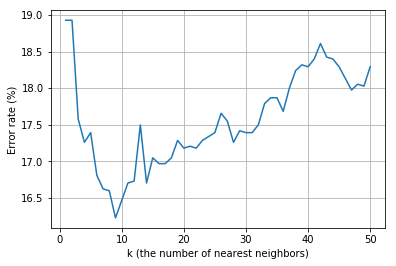

In [16]:
# plot a line chart to show the error rate of different k
plt.plot(range(1, len(error_rate)+1), error_rate*100)

plt.xlabel('k (the number of nearest neighbors)')
plt.ylabel('Error rate (%)')
plt.grid(True)

plt.savefig('error_rate.png', dpi=90)